# Tutorial 5: Vertical Spatial Transcriptomics Integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in vertical integration. Here we take mouse breast cancer sample1 as example. The ST data were generated from our lab (Jinmiao Chen's Lab). Before inputting the model, alignment algorithm was implemented to align sections 1 and 2. 

Please note that aligned position information must be saved in adata.obsm['spatial'] before running the model.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.

In [26]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt

In [27]:
from GraphST import GraphST

In [28]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [29]:
# the number of clusters
n_clusters = 10

## Reading data

In [30]:
# read data
file_fold = '/home/yahui/Yahui/Projects/data/S1_A1_S3_A1/' #please replace 'file_fold' with the download path
adata = sc.read_h5ad(file_fold + 'filtered_feature_bc_matrix.h5ad')
adata.var_names_make_unique()

## Plotting aligned image

Sample labels are saved in adata.obs['data']. 'S1' denotes Section1 while 'S3' denotes Section 2

/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'Aligned image')

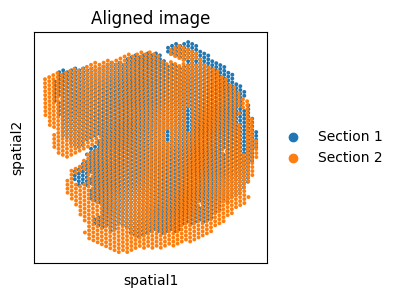

In [31]:
plt.rcParams["figure.figsize"] = (3, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial',
                color='data',
                show=False)
ax.set_title('Aligned image')
#ax.axis('off')

## Implementing GraphST for batch integration

In [32]:
# define model
model = GraphST.GraphST(adata, device=device)

# run model
adata = model.train()

Begin to train ST data...


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 90.18it/s]

Optimization finished for ST data!


## Joint spatial clustering

After model training, the representation for spots are generated and used as input of clustering tool for spatial clustering. Here we provid three available kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [33]:
# clustering
from GraphST.utils import clustering

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01) 

fitting ...
  |======================================================================| 100%


## Plotting UMAP before and after batch effect correction

/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


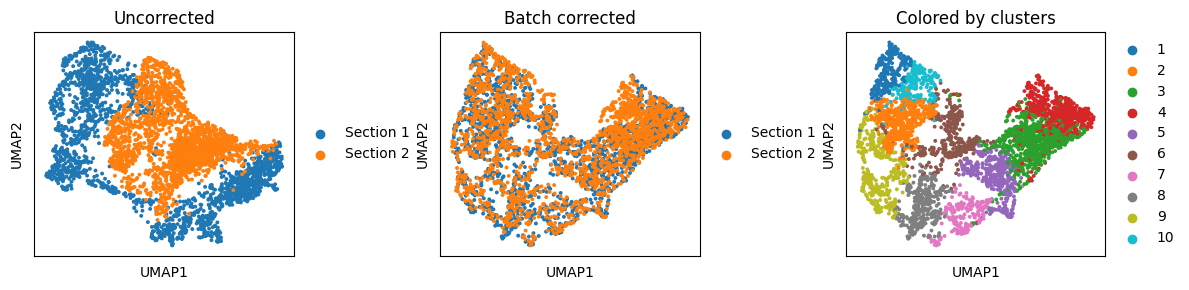

In [34]:
fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))

### Plotting UMAP before batch effect correction
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
    
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Uncorrected', 
                  ax = ax_list[0],
                  show=False)

### Plotting UMAP after batch effect correction
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color='data', 
           ax=ax_list[1], 
           title='Batch corrected', 
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(adata, color='domain', ax=ax_list[2], title='Colored by clusters', show=False)

plt.tight_layout(w_pad=0.02)

## Plotting joint clustering results

For mouse breast cancer sample1, we manually annotated section2 according to H&E image. 
The ground truth labels are avaialbe at https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.  

In [36]:
#from sklearn import metrics
### Splitting adata into Section 1 and Section 2
#adata_section1 = adata[adata.obs['data']=='Section 1', :]
#adata_section2 = adata[adata.obs['data']=='Section 2', :]

#fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
#sc.pl.embedding(adata_section1, 
#                basis='spatial', 
#                color='domain',
#                show = False,
#                s=50,
#                title='Section 1',
#                ax = ax_list[0])

#sc.pl.embedding(adata_section2, 
#                basis='spatial', 
#                color='domain',
#                show = False,
#                s=50,
#                title = ['Section 2'],
#                ax = ax_list[1])

#plt.tight_layout(w_pad=0.2)